### Experiment with outlier detection

In [63]:
import numpy as np
import scipy

from sklearn import svm
from sklearn.linear_model import SGDOneClassSVM
from skimage import measure

# remeshing
import pyvista
import pyacvd
import pymeshfix
import igl

# plotting
import meshplot

# NL additions
import pandas as pd
import os
import glob2 as glob
import trimesh

In [64]:
# get list of refined fin mesh objects
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"

fin_mesh_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*smoothed_fin_mesh*")))
raw_mesh_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*rawfin_mesh*")))
fin_df_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*upsampled*")))
fin_df_c_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*data.csv")))

In [75]:
file_ind = 4

fin_mesh =trimesh.load(fin_mesh_list[file_ind])
raw_fin_mesh =trimesh.load(raw_mesh_list[file_ind])
fin_df = pd.read_csv(fin_df_list[file_ind])
fin_df_c = pd.read_csv(fin_df_c_list[file_ind])

# Fit one class svm

In [81]:
pts = fin_df_c[["YP", "ZP"]].to_numpy() #fin_df_c[["XP", "YP", "ZP", "size"]].to_numpy()

# estimate gamma (scale coefficient) with variance heuristic
# you may need to play with it to get good results, but this is a good starting point
# Make gamma larger to get finer results, make it smaller to get smoother results (less holes)

gamma = 1 / (3 * np.var(pts))

# in this case, I'm making it larger becuase otherwise it fills up the hole
gamma *= 2.5

print(f"gamma: {gamma:.5f}")

gamma: 0.00336


In [82]:
# fraction of data that should be considered outliers
# you can also play with this, generally I found 0.05 - 0.12 to give decent results
outliers = 0.03

In [83]:
# fit the model (can be quite slow!)
model = svm.OneClassSVM(kernel="rbf", gamma=gamma, nu=outliers)
model.fit(pts)

OneClassSVM(gamma=np.float64(0.0033550206143305086), nu=0.03)

In [84]:
y_pred = model.predict(pts)

In [85]:
import plotly.express as px
fin_df["nucleus_id_str"] = fin_df["nucleus_id"].astype(str)
fig = px.scatter_3d(fin_df_c, x="XP", y="YP", z="ZP", color=y_pred)
fig.update_traces(marker=dict(size=4))
fig.show()

In [86]:
import open3d as o3d

# Load or create a point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)  # Nx3 numpy array

# Apply radius outlier removal
filtered_pcd, inlier_indices = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

outlier_flags = np.ones_like(y_pred)
outlier_flags[inlier_indices] = 0

fig = px.scatter_3d(fin_df_c, x="XP", y="YP", z="ZP", color=outlier_flags)
fig.update_traces(marker=dict(size=4))
fig.show()

RuntimeError: Unable to cast Python instance of type <class 'numpy.ndarray'> to C++ type '?' (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

In [74]:
import pyvista as pv

# Convert point cloud to a surface (if needed)
cloud = pv.PolyData(pts)
surf = cloud.delaunay_3d()

# Identify connected regions
connectivity = surf.connectivity()

# Extract the largest connected component (likely the inliers)
inlier_cloud = connectivity.extract_largest()

# fig = px.scatter_3d(fin_df_c, x="XP", y="YP", z="ZP", color=outlier_flags)
# fig.update_traces(marker=dict(size=4))
# fig.show()

KeyError: 'Data named "RegionId" does not exist in this dataset.'

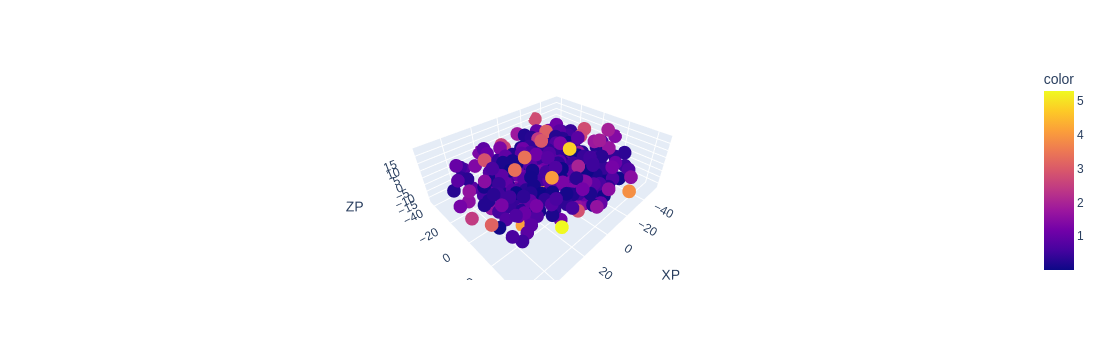

In [27]:
from sklearn.neighbors import KDTree

# quick pass to remove extreme outliers
k_nn = 25

tree = KDTree(fin_df_c[["X", "Y", "Z"]].to_numpy())
dist, ind = tree.query(fin_df_c[["X", "Y", "Z"]].to_numpy(), k=k_nn + 1)

# get avg neighbor distance
nn_mean = np.mean(dist, axis=0)
nn_scale_vec = np.mean(dist[:, 1:3], axis=1)

# average NN dist to get spatially smoothed estimate for inter-nucleus spacing
nn_dist_array = nn_scale_vec[ind[:, 1:]]
se = np.std(nn_dist_array, axis=1)
mu = np.mean(nn_dist_array, axis=1)
out_flags = np.divide(np.abs(nn_scale_vec - mu) , se)

# nn_scale_vec.shape

fig = px.scatter_3d(fin_df_c, x="XP", y="YP", z="ZP", color=out_flags)
fig.show()

In [24]:
ind[1, :]

array([  1,  21,  71, 163, 274,  65,   9, 324,  12,   3,  16, 376,  67,
        13,  38, 272, 268, 208, 160, 206,  66, 155, 161,   2, 100, 143])